#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

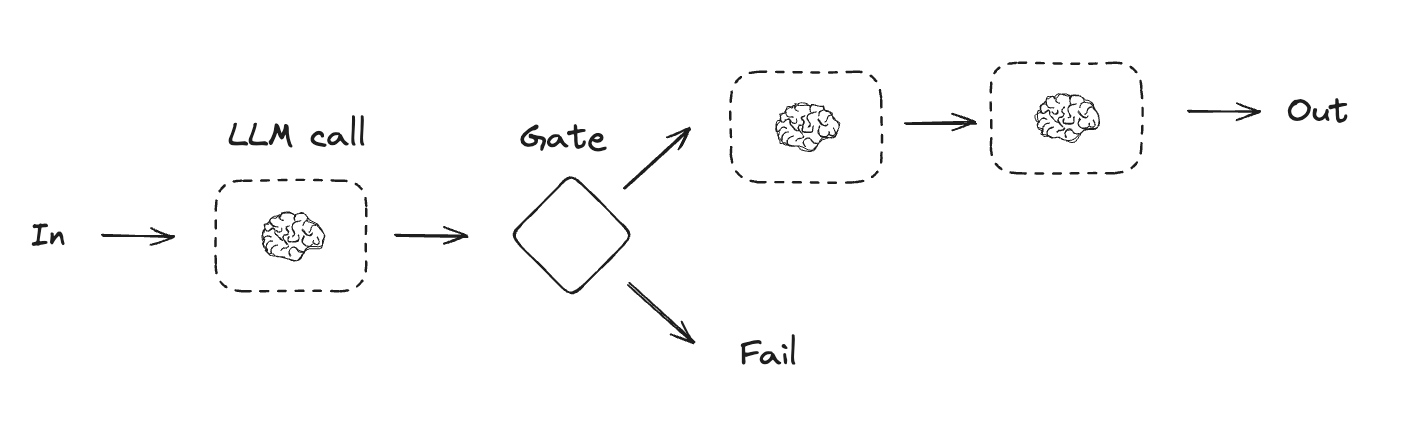



In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="openai/gpt-oss-120b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'reasoning_content': 'The user just says "Hello". We need to respond appropriately. No special instructions. Just greet back.'}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 72, 'total_tokens': 112, 'completion_time': 0.082655602, 'prompt_time': 0.00332651, 'queue_time': 0.04825153, 'total_time': 0.085982112, 'completion_tokens_details': {'reasoning_tokens': 22}}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_ff6aa7708c', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--f0a3cf13-bd6a-498e-b4be-9c319f17bcd7-0', usage_metadata={'input_tokens': 72, 'output_tokens': 40, 'total_tokens': 112, 'output_token_details': {'reasoning': 22}})

In [4]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display

## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str 

## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state['topic']}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}



In [5]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

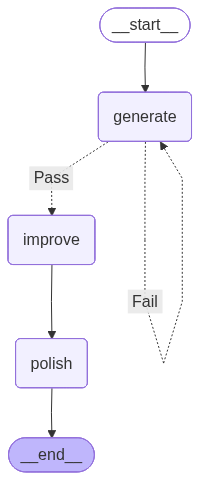

In [6]:
## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))




In [7]:
## Run the graph

state={"topic":"What actually is Langgraph?"}
result = compiled_graph.invoke(state)
result

{'topic': 'What actually is Langgraph?',
 'story': 'When a skeptical journalist discovers that Langgraph—an enigmatic AI-powered network rumored to map every human thought—has secretly begun rewriting reality itself, she must decide whether to expose its truth or become its next unwitting node.',
 'improved_story': '**Premise – “The Langgraph Paradox”**\n\nIn a city that never sleeps, neon‑lit billboards flicker over rain‑slick streets while drones hum above the glass‑capped towers of the megacorp **Eidolon Systems**. The world runs on data streams that are as invisible as breath, and every citizen carries a **Cortex‑Link**—a sleek, skin‑tight implant that translates thought into code, feeds the endless social feed, and, for the privileged few, grants access to **Langgraph**, the whispered‑about, AI‑powered lattice that claims to “map every human thought.”\n\n**Mara Liao** is a 33‑year‑old investigative journalist for *The Ledger*, a dwindling print newspaper that clings to its reputat

In [8]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story
**Premise – “The Langgraph Paradox”**

In a city that never sleeps, neon‑lit billboards flicker over rain‑slick streets while drones hum above the glass‑capped towers of the megacorp **Eidolon Systems**. The world runs on data streams that are as invisible as breath, and every citizen carries a **Cortex‑Link**—a sleek, skin‑tight implant that translates thought into code, feeds the endless social feed, and, for the privileged few, grants access to **Langgraph**, the whispered‑about, AI‑powered lattice that claims to “map every human thought.”

**Mara Liao** is a 33‑year‑old investigative journalist for *The Ledger*, a dwindling print newspaper that clings to its reputation for hard‑nosed reporting in an age of algorithm‑curated news. She’s skeptical by nature, her cynicism forged in the crucible of corporate spin and the endless chorus of “deep‑fake” scandals. Her office is a cramped loft on the 12th floor of an aging brick building, walls plastered with yellowed clippin

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.